
# Music genre identification:
## Visualizing audio features
### John Burt
#### August 2019


[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/projects/tree/master/music_genre_id/music_genre_id_visualize_features_vf.ipynb) 

#### Methods:

- Mean frequency bin amplitudes of harmonic decomposition of the spectrogram.
- Mean, max and median frequency bin amplitudes of tempogram
- Mean MFCC frequency bin amplitudes 


#### Extra packages required:
- librosa



####  Source data:
- The original data is from ["FMA: A Dataset For Music Analysis"](https://github.com/mdeff/fma). That dataset is a dump of sound clips and associated metadata from the Free Music Archive (FMA), an interactive library of high-quality, legal audio downloads. 

- For the meetup series, the music data was reduced further to a "warmup set" of 4000 samples of folk and 4000 samples of hip-hop music. This code uses the warmup set, but is also tooled to use the original music clip dataset, which is much larger and has more genre categories.

In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np

import librosa
import librosa.display

srcdir = './warmup/'

# metadata file name
metadatafile = 'pdsg_musicgenre_warmup_small.csv'

# read the metadata file
df = pd.read_csv(srcdir+metadatafile)

# add filename col
df['filename'] = ['%06d.wav'%i for i in df['track_id']]


## Load an example music clip.



In [2]:
# select a song by track ID
# # track_id = 152543
# track_id = 145728
track_id = 130944

inf = df[df.track_id==track_id]

filepath = srcdir+str(track_id)+'.wav'

print('reading file',inf['filename'])
print('name:',inf['name'])
print('type:',inf['genre_top'])

y, sr = librosa.load(filepath, offset=0, duration=10, sr=None)

print('\nnumber of samples in clip =',y.shape[0], 'sample rate =', sr)

reading file 1    130944.wav
Name: filename, dtype: object
name: 1    La Cantine Boga
Name: name, dtype: object
type: 1    Folk
Name: genre_top, dtype: object

number of samples in clip = 80000 sample rate = 8000


## Compute the spectrogram

Decompose spectrogram into harmonic and percussive components.

In [3]:
hoplength=None
fftsize=256
D = librosa.stft(np.array(y), hop_length=hoplength, n_fft=fftsize)
print('D.shape =', D.shape)

D_harmonic, D_percussive = librosa.decompose.hpss(D)

D.shape = (129, 1251)


## Display spectrographs

Plot the two decomposition components along with the original spectrogram

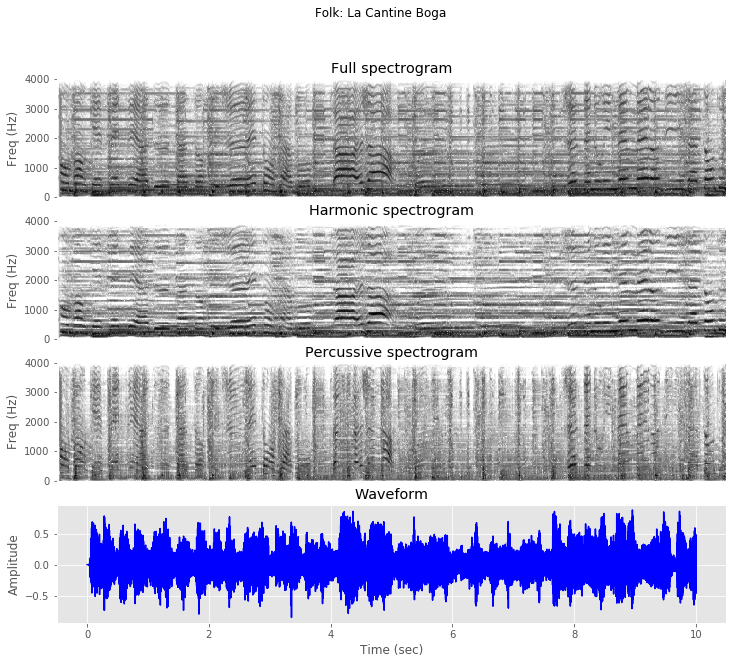

In [19]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 10))

plt.suptitle(inf['genre_top'].iloc[0] + ': ' + inf['name'].iloc[0])

plt.subplot(4, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),ref=rp), 
                         sr=sr, y_axis='linear',cmap='Greys')
plt.ylabel('Freq (Hz)')
# plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(4, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic),ref=rp), 
                         sr=sr, y_axis='linear',cmap='Greys')
plt.ylabel('Freq (Hz)')
# plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(4, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive),ref=rp), 
                         sr=sr, y_axis='linear',cmap='Greys')
# plt.colorbar()
plt.ylabel('Freq (Hz)')
plt.title('Percussive spectrogram')

plt.subplot(4, 1, 4)
time_x = np.array(range(y.shape[0]))/sr
plt.plot(time_x,y, 'b-')
plt.ylabel('Amplitude')
plt.xlabel('Time (sec)')
plt.title('Waveform');



## Reduce noise in spectrograms

Noise components show up in both the harmonic and percussive decomposition components. Setting the margin parameter > 1 during decomposition reduces noise and gives better separation of harmonic and percussive components. 

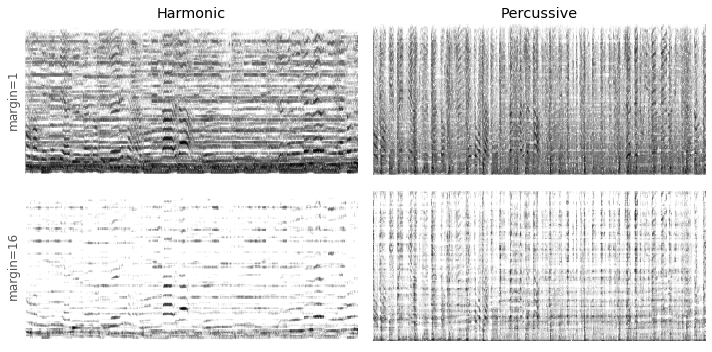

In [22]:
# decomposition using margin = 16
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.title('Harmonic')
plt.yticks([])
plt.ylabel('margin=1')

plt.subplot(2, 2, 2)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.title('Percussive')
plt.yticks([]), plt.ylabel('')

plt.subplot(2, 2, 3)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_harmonic16), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.yticks([])
plt.ylabel('margin=16')

plt.subplot(2, 2, 4)
librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(D_percussive16), ref=rp), 
    sr=sr, y_axis='linear',cmap='Greys')
plt.yticks([]), plt.ylabel('')

plt.tight_layout()
plt.show()

## Averaged FFTs of original vs decomposed harmonic spectrogram

How does decomposition with a margin filter affect the overall spectra of a spectrogram? 

Comparing the spectra (mean row magnitudes), it's clear that the harmonic component is now more contrasty, which reflects removal of noise components, especially in the lower frequency range. 

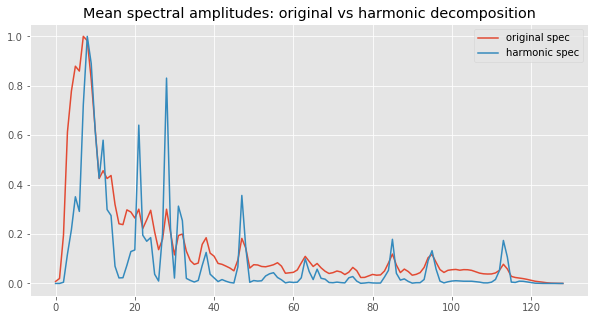

In [23]:
# mean spectrum original
meanfreq = np.mean(np.abs(D), axis=1)
# mean spectrum harmonic
meanfreq_h = np.mean(np.abs(D_harmonic16), axis=1)

plt.figure(figsize=(10,5))
plt.plot(range(len(meanfreq)), meanfreq/max(meanfreq), label='original spec');
plt.plot(range(len(meanfreq_h)), meanfreq_h/max(meanfreq_h), label='harmonic spec');
plt.legend()
plt.title('Mean spectral amplitudes: original vs harmonic decomposition');


## Averaged spectral magnitudes of original vs decomposed percussive spectrogram

How does decomposition with a margin filter affect the spectral magnitudes at each FFT time point? 

Comparing the energy at each time point (mean column magnitudes) you see the same separation effect: at each time point there is less noise and percussive beats are more noticeable.

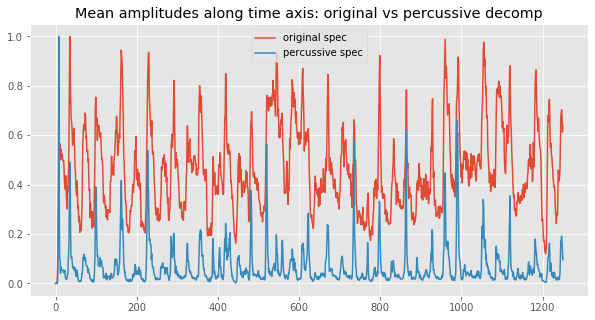

In [24]:
# mean percussive vs original

meantime = np.mean(np.abs(D), axis=0)
meantime_p = np.mean(np.abs(D_percussive16), axis=0)

plt.figure(figsize=(10,5))
plt.plot(range(len(meantime)), meantime/max(meantime), label='original spec');
plt.plot(range(len(meantime_p)), meantime_p/max(meantime_p), label='percussive spec');
plt.legend();
plt.title('Mean amplitudes along time axis: original vs percussive decomp');


# Looking at the tempogram

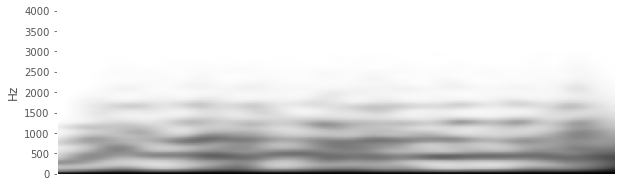

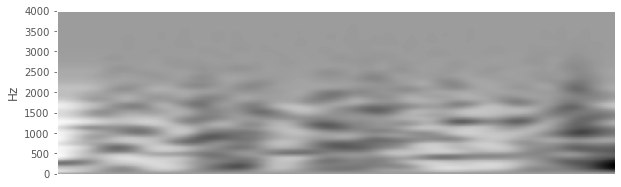

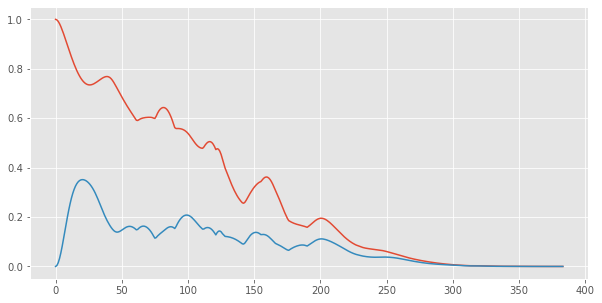

In [36]:
hop_length = 50
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                       hop_length=hop_length)

plt.figure(figsize=(10,3))
tempmag = np.abs(tempogram)
librosa.display.specshow(tempmag, sr=sr, y_axis='linear',cmap='Greys');

plt.figure(figsize=(10,3))
t3 = (tempmag.T - np.mean(tempmag, axis=1).T).T
librosa.display.specshow(t3, sr=sr, y_axis='linear',cmap='Greys');

plt.figure(figsize=(10,5))
plt.plot(range(tempogram.shape[0]), np.max(tempogram, axis=1))
plt.plot(range(t3.shape[0]), np.max(t3, axis=1));
